Index(['SystemTime', 'RDTSC', 'Elapsed Time (sec)', 'CPU Utilization(%)',
       'CPU Frequency_0(MHz)', 'CPU Min Frequency_0(MHz)',
       'CPU Max Frequency_0(MHz)', 'CPU Requsted Frequency_0(MHz)',
       'Processor Power_0(Watt)', 'Cumulative Processor Energy_0(Joules)',
       'Cumulative Processor Energy_0(mWh)', 'IA Power_0(Watt)',
       'Cumulative IA Energy_0(Joules)', 'Cumulative IA Energy_0(mWh)',
       'Package Temperature_0(C)', 'Package Hot_0', 'CPU Min Temperature_0(C)',
       'CPU Max Temperature_0(C)', 'DRAM Power_0(Watt)',
       'Cumulative DRAM Energy_0(Joules)', 'Cumulative DRAM Energy_0(mWh)',
       'Package Power Limit_0(Watt)', 'GT Frequency(MHz)',
       'GT Requsted Frequency(MHz)"'],
      dtype='object')


185.8007725

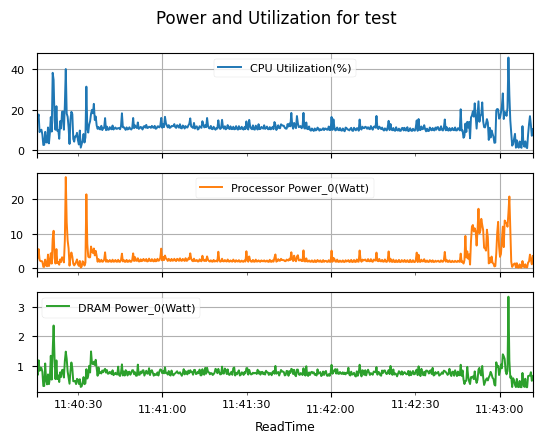

In [1]:
import pandas as pd
import csv
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-paper')

fpath = "/Users/gabemersy/Desktop/vldb vision paper/device_power/power_logging_2min_video.csv"
refresh_rate = 333
df = pd.read_csv(fpath, engine='python', delimiter='","')
df.drop(df.tail(11).index,
        inplace = True)
df.head()
df.replace('"', '', regex=True, inplace=True)
df.rename(columns={'"System Time': 'SystemTime'}, inplace=True)

print(df.columns)
df['SystemTime'] = [value[:-3]+str(int(value.split(':')[-1])*1000) for value in df['SystemTime'].tolist()]

df['SystemTime'] = pd.to_datetime(df['SystemTime'], format="%H:%M:%S:%f").dt.time


read_times = [datetime.combine(datetime.today(), df['SystemTime'].values[0])]

for i in range(1, df.shape[0]):
    read_times.append(read_times[0] + timedelta(milliseconds=i*refresh_rate))

df['ReadTime'] = read_times


relevant_data = df[['ReadTime', 'SystemTime', 'CPU Utilization(%)', 'Processor Power_0(Watt)', 'DRAM Power_0(Watt)']]



def query_relevant_data(relevant_data, start_time, end_time):
    return relevant_data[(relevant_data['ReadTime'] >= start_time) & (relevant_data['ReadTime'] <= end_time)]


def plot(view, task, outfile):
    view = view.sort_values(by=['ReadTime'])
    view = view.set_index('ReadTime')
    view.plot(kind='line', subplots=True, grid=True, title="Power and Utilization for {}".format(task), layout=(3, 1), sharex=True, legend=True)


plot(relevant_data, "test", "test.png")
relevant_data.head()


def compute_energy(view, sample_rate, unit = 'kWh'):
    view = view.sort_values(by=['ReadTime'])
    joules_wattsecs = (sample_rate*(view['Processor Power_0(Watt)'] + view['DRAM Power_0(Watt)'])).sum()
    return joules_wattsecs if unit != 'KWh' else joules_wattsecs/3600000 


compute_energy(relevant_data, 333000, unit='KWh')